## Bandit task approach

In [2]:
import numpy as np                 
import matplotlib.pyplot as plt

In [3]:
def k_armed_bandit(k):
    arm_means = np.random.random(k)  # np.random.randint(0, 5, k)    
    return arm_means

### Single Agent solving bandit

In [4]:
def epsilon_greedy(values, epsilon, rng = np.random.default_rng()):
    """Action selection: epsilon greedy"""
    if np.max(values) == 0 or rng.random() <= epsilon:
        return rng.integers(len(values))
    else:
        return np.argmax(values)


In [5]:
def softmax_selection(values, rng):
    probs = np.exp(values) / np.sum(np.exp(values))
    return rng.choice(np.arange(len(probs)), p=probs)

In [6]:
def rescola_wagner_update(values, iteration, reward, action, eta):
    
    values[iteration+1] = values[iteration]
    values[iteration+1, action] = values[iteration,action] + eta * (reward - values[iteration, action])
    return values

[0.31195534 0.37817805 0.59204781 0.965305  ]


Text(0, 0.5, 'bandit value')

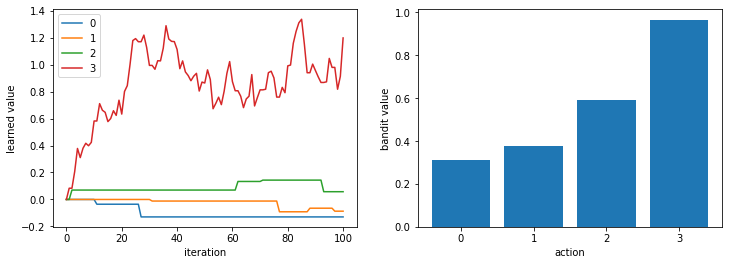

In [7]:
iterations = 100
k = 4
eta = 0.1
epsilon=0.2
arm_values = k_armed_bandit(k)
rng = np.random.default_rng(seed=0)

print(arm_values)

values = np.zeros((iterations+1, k))
for i in range(iterations):
    # Action selection
    action = epsilon_greedy(values[i], epsilon, rng)
    # action = softmax_selection(values[i], rng)
    
    # Execute action
    reward = rng.normal(arm_values[action])
    # reward = arm_values[action]
    
    # Learning update
    values = rescola_wagner_update(values, i, reward, action, eta)


# Plots
fig, axs = plt.subplots(1,2, figsize=(12,4))
for _ in range(k):
    axs[0].plot(values[:,_], label=_)
axs[0].legend()
axs[0].set_xlabel("iteration")
axs[0].set_ylabel("learned value")
axs[1].bar(height=arm_values, x=np.arange(k).astype(str))
axs[1].set_xlabel("action")
axs[1].set_ylabel("bandit value")


### Multiple agents

In [8]:
def plot_agent_values(n_agents, values, epsilon):
    fig, axs = plt.subplots(1, n_agents, figsize=(5*n_agents,4),sharey=True)
    for agent in range(n_agents):
        axs[agent].set_title(f"Agent#{agent}")
        for _ in range(k):
            axs[agent].plot(values[:,agent,_], label=_)
        axs[agent].legend()
        axs[agent].set_xlabel("iteration")
        axs[agent].set_ylabel("learned value")
    if type(epsilon) != float:
        for agent in range(n_agents):
            axs[agent].set_title(f"Agent#{agent} $\epsilon$={round(epsilon[agent], 3)}")

    plt.show()

In [9]:
def ma_epsilon_greedy(values, epsilon, k, rng):
    """epsilon: float or array size (n)"""
    if values.sum() == 0:
        return rng.integers(0, k, len(values))
    n, k = values.shape
    actions = np.argmax(values, axis=1)
    # epsilon part
    random_action_index = np.where(rng.random(n) <= epsilon)[0]
    actions[random_action_index] = rng.integers(0,k, len(random_action_index))
    return actions

In [10]:
def ma_softmax_selection(values, beta=1, rng=None):
    exponentials = np.exp(values * np.array(beta).reshape(-1,1))
    probs = exponentials/ np.sum(exponentials ,axis=1, keepdims=True)
    return np.array([rng.choice(np.arange(probs.shape[1]), p=probs[a], shuffle=False) for a in range(n_agents)])

In [32]:
def ma_rescola_wagner_update(values, iteration, rewards, actions, eta):
    
    values[iteration+1] = values[iteration]
    for n in range(n_agents):
        TDE = (rewards[n] - values[iteration][n][actions[n]])
        values[iteration+1][n][actions[n]] = values[iteration][n][actions[n]] + eta * TDE
    return values

[0.69229154 0.2353359  0.7779189 ]


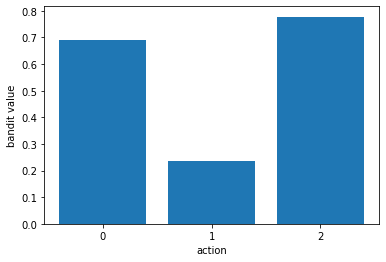

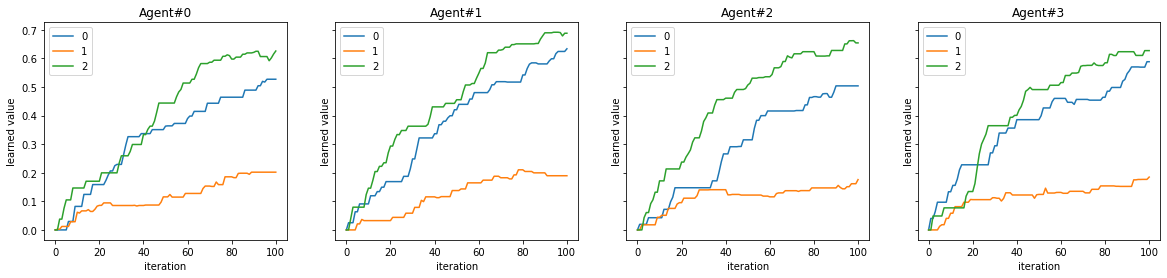

In [33]:
n_agents = 4
iterations = 100
k = 3
eta = 0.05
epsilon = 0.2
# epsilon = np.linspace(0.1,.5,n_agents)

arm_values = k_armed_bandit(k)
rng = np.random.default_rng(seed=0)

print(arm_values)

values = np.zeros((iterations+1, n_agents, k))


for i in range(iterations):
    # Action selection
    # actions = ma_epsilon_greedy(values[i], epsilon, k, rng)
    actions = ma_softmax_selection(values[i], 1, rng)
    
    # Execute action
    rewards = np.random.normal(arm_values[actions], scale=0.2)
    # rewards = arm_values[actions]
    
    # Learning update
    values = ma_rescola_wagner_update(values, i, rewards, actions, eta)


# Plots
plt.bar(height=arm_values, x=np.arange(k).astype(str))
plt.xlabel("action")
plt.ylabel("bandit value")
plt.show()

plot_agent_values(n_agents, values, epsilon)


Ideas impacting policy
- Good/ Bad performance: Find correlation between agents parameters and individual performance ($\epsilon$, $\eta$)


---
Impact of information distribution
- several bandits &rarr; every agent performs good in one bandit 
    - &rarr; need to share information so everybody is good
- Bandit arms depend on how many agents choose the same arm
    - Cooperation and Information sharing benefits individuals
- Problem: There could be a chain of following instead of one **leader**
    - &rarr; A need to model a shared understanding of granting influence
    - The amount of "followers" over time as **prestige** influencing granting
    - **Cost** of communication (long connections are penalized)

---
**Diversity** impact
- It represents information contained in a group (some is more or less useful)
- 
        

## Cooperative bandit

In [34]:
def plot_bandit_value(n_agents, coop_strategy):
    x = np.arange(n_agents)
    payoff= np.ones(n_agents)*n_agents
    y = np.zeros(n_agents)

    for po in x:
        payoff[po] = 0
        rewards = coop_bandit(k, payoff, coop_strategy)
        y[po] = rewards[0]

    plt.bar(x=x+1, height=y)
    plt.xlabel("Number of agents choosing the same action")
    plt.ylabel("Payoff for an action")
    plt.show()

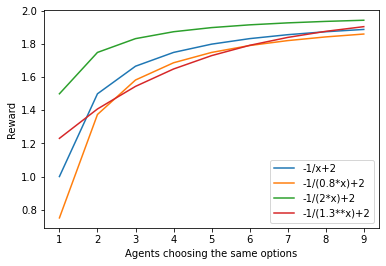

In [35]:
# Reward dependnecy on Cooperation
x=np.arange(1,10)
plt.plot(x, -1/x+2, label="-1/x+2")
plt.plot(x, -1/(0.8*x)+2, label="-1/(0.8*x)+2")
plt.plot(x, -1/(2*x)+2, label="-1/(2*x)+2")
plt.plot(x, -1/(1.3**x)+2, label="-1/(1.3**x)+2")
# plt.plot(x)

plt.xlabel("Agents choosing the same options")
plt.ylabel("Reward")
plt.legend()

In [36]:
def coop_bandit(k, actions, strategy="1/n"):
    assert strategy in ["1/n", "linear"]
    
    action, counts = np.unique(actions, return_counts=True)
    
    if strategy == "1/n":
        payout = (-1/counts + 2) # * 1/k
    elif strategy == "linear":
        payout = counts
    
    rewards = np.zeros(len(actions))
    for i, a in enumerate(action):
        rewards[actions == a] = np.round(payout[i],2)
    
    return rewards


coop_bandit(3, np.array([0,1,1,2]), strategy="linear")

array([1., 2., 2., 1.])

In [37]:
coop_bandit(3, np.array([1,3,3,3,3,8]))

array([1.  , 1.75, 1.75, 1.75, 1.75, 1.  ])

**With epsilon_greedy**

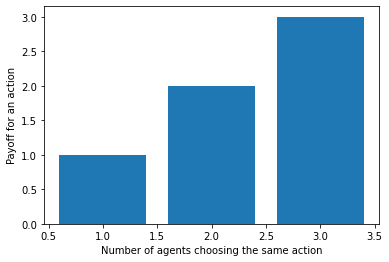

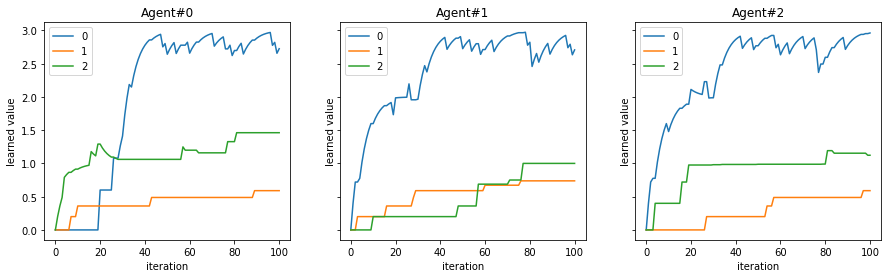

In [39]:
n_agents = 3
iterations = 100
k = 3
eta = 0.2
beta = 1
epsilon = 0.2
# epsilon = np.linspace(0.1,.5,n_agents)

seed = np.random.randint(100)# 0
rng = np.random.default_rng(seed=seed)

coop_strategy = "linear"  # "1/n"

values = np.zeros((iterations+1, n_agents, k))
action_tracker = np.zeros((iterations, n_agents))

for i in range(iterations):
    # Action selection
    actions = ma_epsilon_greedy(values[i], epsilon, k, rng)
    # actions = ma_softmax_selection(values[i], beta, rng)
    current_actions, counts = np.unique(actions, return_counts=True)
    action_tracker[i][current_actions] = counts
    
    # Execute action
    rewards = coop_bandit(k, actions, coop_strategy)
    
    # Learning update
    values = ma_rescola_wagner_update(values, i, rewards, actions, eta)


# Plots
## Bandit value
plot_bandit_value(n_agents, coop_strategy)

## Agent value
plot_agent_values(n_agents, values, epsilon)

Text(0.5, 0, 'Iteration')

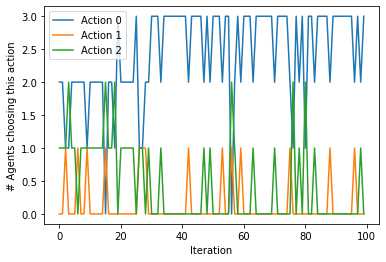

In [40]:
for action in range(k):
    plt.plot(action_tracker[:,action], label=f"Action {action}")
plt.legend()
plt.ylabel("# Agents choosing this action")
plt.xlabel("Iteration")

**With softmax**

[0.69229154 0.2353359  0.7779189 ]


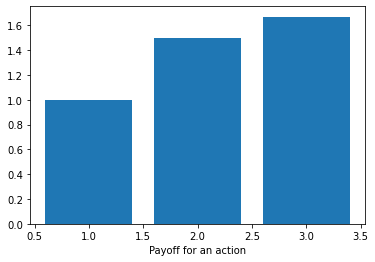

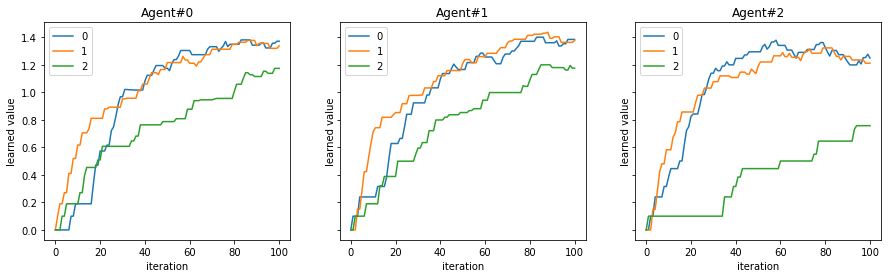

In [41]:
n_agents = 3
iterations = 100
k = 3
eta = 0.1
epsilon = 0.2
beta = 1.5
coop_strategy = "1/n" # "linear"
# epsilon = np.linspace(0.1,.5,n_agents)

seed = np.random.randint(100)# 0
rng = np.random.default_rng(seed=seed)

print(arm_values)

values = np.zeros((iterations+1, n_agents, k))

action_tracker = np.zeros((iterations, n_agents))

for i in range(iterations):
    # Action selection
    # actions = ma_epsilon_greedy(values[i], epsilon, k, rng)
    actions = ma_softmax_selection(values[i], beta, rng)
    current_actions, counts = np.unique(actions, return_counts=True)
    action_tracker[i][current_actions] = counts
    
    # Execute action
    rewards = coop_bandit(k, actions, strategy=coop_strategy)
    
    # Learning update
    values = ma_rescola_wagner_update(values, i, rewards, actions, eta)


# Plots
## Bandit value
x = np.arange(n_agents)
payoff= np.ones(n_agents)*n_agents
y = np.zeros(n_agents)

for po in x:
    payoff[po] = 0
    rewards = coop_bandit(k, payoff, coop_strategy)
    y[po] = rewards[0]
    
plt.bar(x=x+1, height=y)
plt.xlabel("Number of agents choosing the same action")
plt.xlabel("Payoff for an action")
plt.show()

## Agent value
plot_agent_values(n_agents, values, epsilon)


Text(0.5, 0, 'Iteration')

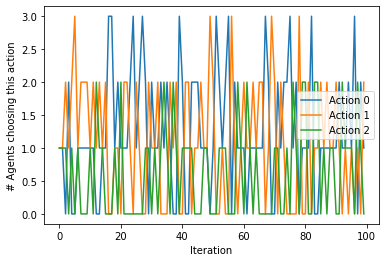

In [42]:
for action in range(k):
    plt.plot(action_tracker[:,action], label=f"Action {action}")
plt.legend()
plt.ylabel("# Agents choosing this action")
plt.xlabel("Iteration")

- $\eta$ Learning rate: If high, values get so fast adjusted that single arms can stand out. If its low, all arms are learned equally and limit at the same point due to fast arm switching
- $\beta$ Inv. Temp: highly scales cooperation, as it fosters exploitation
- $\epsilon$ Greedy:  Less greedy agents don't follow the best strategy so clearly - less cooperation on one arm

In [44]:
for b in np.arange(1, 5):
    exps = np.exp(np.arange(1,4)*b)
    print(f"{b} Agents: ", exps/ exps.sum())
# Probabilities if agents succesfully learned one arm

1 Agents:  [0.09003057 0.24472847 0.66524096]
2 Agents:  [0.01587624 0.11731043 0.86681333]
3 Agents:  [0.00235563 0.04731416 0.95033021]
4 Agents:  [3.29320439e-04 1.79802867e-02 9.81690393e-01]


&rarr;
- Greedy policy establishes basis to cooperate
    - greed agents pursue one action, other agents learn to follow their lead while exploring
- Softmax policy leads to higher variation in actions and less cooperation
    - Agents change policy frequently due to similar payoffs. High changes lead to overlapping strategies
    - No shared behaviour emerges
    - Higher value for cooperation may change this behaviour
    
- *Interesting*: Greedy strategies are bad for the group mean, but can lead to full cooperation, whereas more flexible behaviour is steady over time, but does not reach the peak due to a lack of exploitation


- Everything highly depends on the chosen reward distribution and learning rate

## Multiple bandits
A group of agents solving the same bandits

In [45]:
def n_k_armed_bandit(n, k):
    arm_means = np.random.random((n,k))  # np.random.randint(0, 5, k)    
    return arm_means

In [46]:
def group_softmax_selection(values, beta, rng):
    probs = np.exp(values*beta) / np.sum(np.exp(values*beta),axis=-1, keepdims=True)
    return np.array([rng.choice(np.arange(probs.shape[-1]), p=probs[a][n], shuffle=False)
                     for n in range(n_bandits) 
                     for a in range(n_agents)]
                   ).reshape(n_agents, n_bandits)

In [47]:
def group_rescola_wagner_update(values, iteration, rewards, action, eta):
    
    values[iteration+1] = values[iteration]
    if type(eta) == float:
        eta *= np.ones(n_agents)
    for ag in range(n_agents):
        for b in range(n_bandits):
            values[iteration+1][ag][b][actions[ag][b]] = values[iteration][ag][b][actions[ag][b]] + eta[ag] * (rewards[ag][b] - values[iteration][ag][b][actions[ag][b]])
    return values

In [48]:
def plot_bandit_values(n_bandits, arm_values, k):
    fig, axs = plt.subplots(1, n_bandits, figsize=(5*n_bandits,4),sharey=True)
    for bandit in range(n_bandits):
        axs[bandit].bar(height=arm_values[bandit], x=np.arange(k).astype(str))
        # axs[bandit].legend()
        axs[bandit].set_xlabel("actions")
        axs[bandit].set_ylabel("Value (Mean, std=0.1)")
        axs[bandit].set_title(f"Bandit #{bandit}")

    plt.show()

In [49]:
def plot_agent_values_mb(n_agents, values, n_bandits):
    fig, axs = plt.subplots(n_bandits, n_agents, figsize=(5*n_agents,5*n_bandits),sharey=True, sharex=True)
    for agent in range(n_agents):
        for bandit in range(n_bandits):
            axs[bandit][agent].set_title(f"Agent#{agent}")
            for _ in range(k):
                axs[bandit][agent].plot(values[:,agent,bandit,_], label=f"arm #{_}")
            axs[bandit][agent].legend()
            axs[bandit][agent].set_xlabel("iteration")
            axs[bandit][agent].set_ylabel("learned value")

    plt.show()

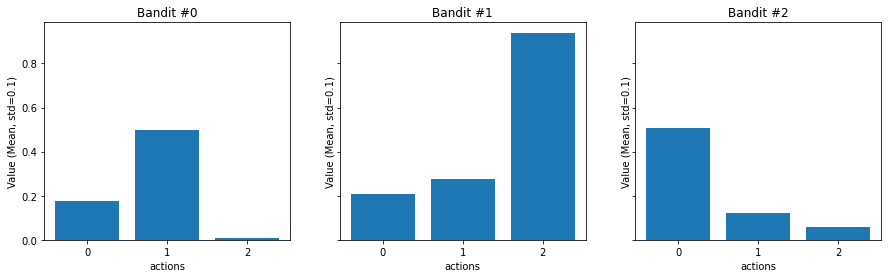

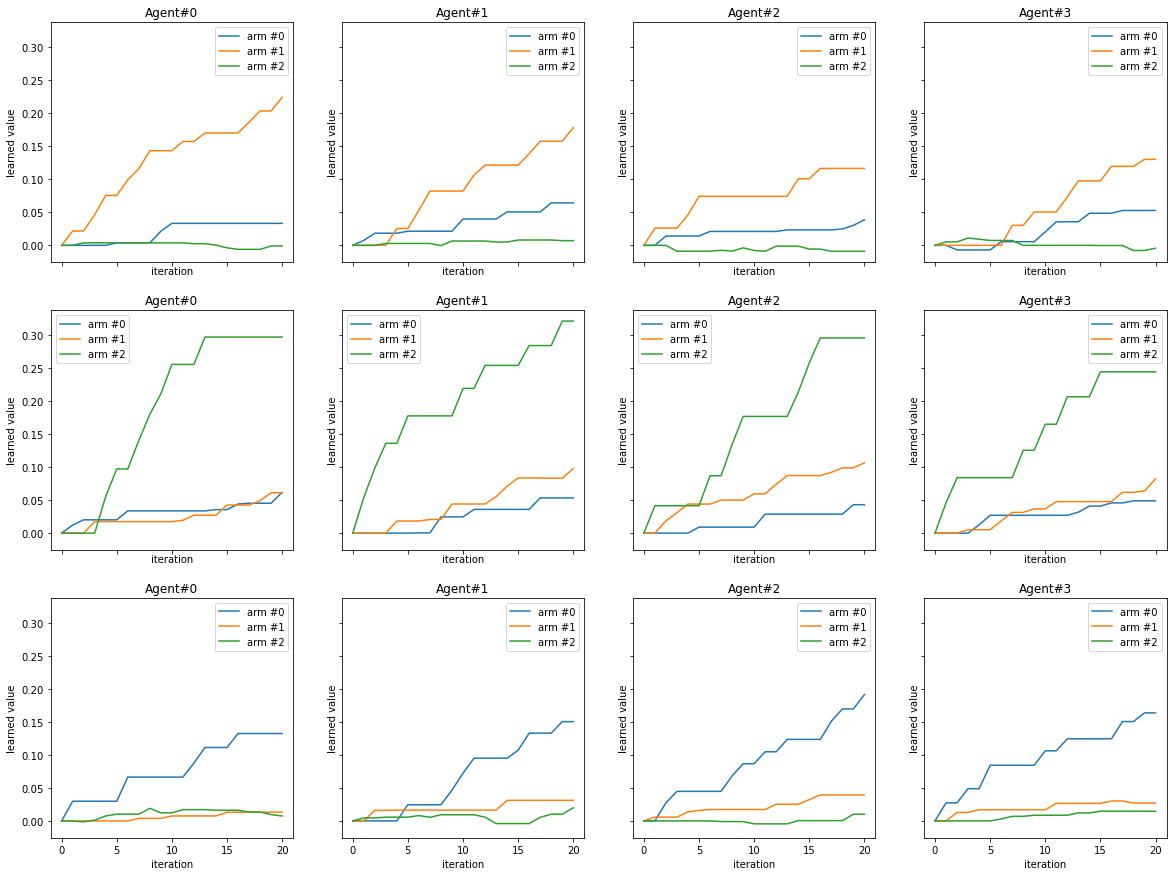

In [50]:
n_agents = 4
n_bandits = 3
iterations = 20
k = 3
eta = 0.05
beta=1

arm_values = n_k_armed_bandit(n_bandits, k)
rng = np.random.default_rng(seed=0)


values = np.zeros((iterations+1, n_agents, n_bandits, k))


for i in range(iterations):
    # Action selection
    actions = group_softmax_selection(values[i], beta, rng)
    
    # Execute action
    rewards = np.zeros((n_agents, n_bandits))
    for agent in range(n_agents):
        for bandit in range(n_bandits):
            rewards[agent, bandit] = np.random.normal(arm_values[bandit][actions[agent, bandit]], scale=0.1)
        # rewards = arm_values[actions]
    
    # Learning update
    values = group_rescola_wagner_update(values, i, rewards, actions, eta)


# Plots

plot_bandit_values(n_bandits, arm_values, k)

plot_agent_values_mb(n_agents, values, n_bandits)


## Model design

**Objective**: Understand dynamics in information sharing throughout a cooperation task, which impact leader emerge  


**Diversity specific**:
- Which diversity aspects produce which biases
- Introduce biases/ privilege in first place and observe differences in the dynamic


**Measurements**:
- Fix round of iteration or quit with convergence
- Measurement of cooperation
    - Max value of an option in last iteration?
    


**Decision policy**
- Individual: 
    - Softmax + Inverse temperature
    - For one bandit: $\pi_{i} = exp(v_i  \beta) / \sum_j exp(v_{i,j}  \beta) $
- Social:
    - Action of one agent or the whole group 
        - Measures can be based on social influence or performance
    - Copy next action of one "leader"
    - Take next action into softmax policy
    - Choose between individual and social action with probability (gamma)
    - Action for multiple bandits

**Social Influence**
- Reinforcement of social influence
    - Individual for every agent
    - Just on performance of other agents
    - What is the feedback for social influence/ learning 
        - Someone elses performance?
        - The estimated difference to the own performance
        - 
- "Leadership" definition:
    - If agents only choose one other they have a clear favorite
    - In a fully connected network:
        - Compare distribution of weights &rarr; Leaders should have a higher mean
        - Hypothesis Test if it could still the same underlying distribution 
- Social Network:
    - Fully connected network with weights in both directions
    - Weights represent social influence

- Ideas:
    - Ability to see social influence of others
    - Influence as a limited ressource per agent (1, everyone starts with 1/n social influence)
    - Leadership scores: One number for every agent, the higher, the more likely to follow this agent



**Communication**   
Information distribution:
- "Information" &rarr; prior knowledge about values of arms 
    - True underlying value
    - Value close to true value with certain probability (How certain are you that the knwon value is true - like hypothesis testing)
    - Just some values at the beginning to fasten learning
- After each iteration
- Individually to other agents or voting as a group


**Bandits**
- Should represent aspects of Teamwork
- *cooperative* bandits (reverse competitive):
    - The more agents choose the same behaviour, the more value it will bring
    - Still have different performances on the arms (joining on the worst is better then not cooperating, but a lot worse then the coop on the best)
    - May represent:
        - Shared perceptions: Following the same vision, behaving to the same rules
        - Improved teamwork due to alignment (like using similar techniques and therefore work faster (f.e. google slides or OneNote)
        - Further Example: Expert knowledge in application domain: Let's use Jira, if we all join, this will be the best possible option. Other are no expert in this area an learned their favorite individually (OneNote, slides, ...)
            - Social influence to the expert
        
- Normally distributed bandits
    - Just search for the best working strategy
- Number of bandits:
    - Just fix to 3,4,5? as representative
    - n_bandits = n_agents  to distribute information equally in an easy way
    
    
    
**Diversity**
- Individual information
    - can be seen as skills
    - but also as privilege?? Is prior information policy relevant?
- self efficacy:
    - How strong the will to influence or the confidence is
- Motivation to lead:
    - Different aspects
- Visible diversity:
    - race/ age/ gender
    
    


**Math policy**

- Individual policy $\pi_{i} = \frac{exp(v_i  \beta)}{\sum_j exp(v_{i,j}  \beta)} $


- Social policy:
    - Softmax of other agents values for one bandit $\pi_{i} = \frac{exp(v_i)}{\sum_j exp(v_{i,j}  \beta)} $


**Necessary behaviour**
- Behaviour without any biases or individualities involved:
- Leadership = information_sharing(groups_members)
1. With everyone exactly equal NO leader should emerge (in the sum of runs) &rarr; unbiased mechanics
2. Information posession should lead to leadership in a context without individual features

**Technologies may be helpful**
- **Interpolation** between points to create a fitness landscape, or an individual perception of the fitness landscape
- **Bayes** rule: Use posterior to determine probability of a decision, given a (leadership/ diversity) value
    - Use Prior to model biases?
- **Treshold**: Use treshold functions for activity and communications




---

#### Experiment design
- online experiment
- Include minorities in goups
- Group solves bandit tasks 
    - bandits could be labelled abstract as (strategy 1; norm set 1; descision rules 1)
- Every person has to choose an arm for every bandit every iteration
- Communication has to be limited


**To fit the model**
- Model aspects representing diversity with parameter how strong they are
- Set them at different stages of the social influence granting process
- Diversity parameter can be fit onto data

---

### Information distribution (skill)

- Information which arm works best
- Ranking of arms
- Information about the distribution of one bandit
- Distribution across arms

Parameters of information:
- Uncertainty of information
- Amount of information

### Cooperative reward in multiple bandits (with arm values)

In [51]:
n_agents = 4
n_bandits = 3
iterations = 40
k = 3
eta = 0.2
beta = 1.5

seed = 0

In [52]:
arm_values = n_k_armed_bandit(n_bandits, k)
arm_values

array([[0.81613107, 0.1776469 , 0.70393437],
       [0.21432743, 0.55038753, 0.8447284 ],
       [0.2089811 , 0.99168704, 0.63068684]])

Text(0.5, 1.0, 'Arm distribution of the first bandit')

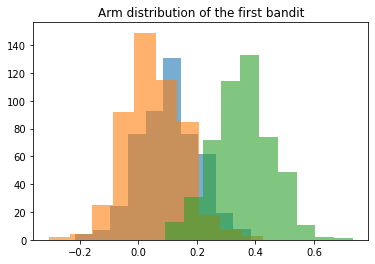

In [59]:
for i in range(len(arm_values[0])):
    plt.hist(np.random.normal(arm_values[0,i], 0.1, 500), alpha=0.6)
plt.title("Arm distribution of the first bandit")

In [60]:
def coop_bandit_multiplier(n_agents, strategy="1/n"):
    assert strategy in ["1/n", "linear"]
    x = np.arange(1, n_agents+1)
    if strategy == "1/n":
        multiplier = (-1/x + 2) # * 1/k
    elif strategy == "linear":
        multiplier = x
    
    # multiplier = multiplier/ multiplier.max()
    
    return multiplier

coop_multiplier = coop_bandit_multiplier(n_agents, strategy="linear")
coop_bandit_multiplier(n_agents, strategy="linear"), coop_bandit_multiplier(n_agents), 

(array([1, 2, 3, 4]), array([1.        , 1.5       , 1.66666667, 1.75      ]))

In [61]:
def gauß_reward(arm_values, actions, n_agents, n_bandits, rng):
    rewards = np.zeros((n_agents, n_bandits))
    for agent in range(n_agents):
        for bandit in range(n_bandits):
            rewards[agent, bandit] = rng.normal(arm_values[bandit][actions[agent, bandit]], scale=0.1)
    return rewards

In [62]:
def cooperative_reward(actions, arm_values, coop_multiplier, k):
    rewards = np.zeros((n_agents, n_bandits))
    
    for a in range(k):
        arm_actions = actions[:,a]
        arm_rewards = arm_values[a][arm_actions]
        unique_actions, action_counts = np.unique(arm_actions, return_counts=True)
        for unique_action_index in range(len(unique_actions)):
            applied_index = arm_actions == unique_actions[unique_action_index]
            reward = arm_rewards * coop_multiplier[action_counts[unique_action_index]-1]
            rewards[:,a] = reward
    return rewards 

# cooperative_reward(actions, arm_values, coop_multiplier, k)


In [63]:
n_agents = 4
n_bandits = 3
iterations = 40
k = 3
eta = 0.2
beta = 2

seed = 0

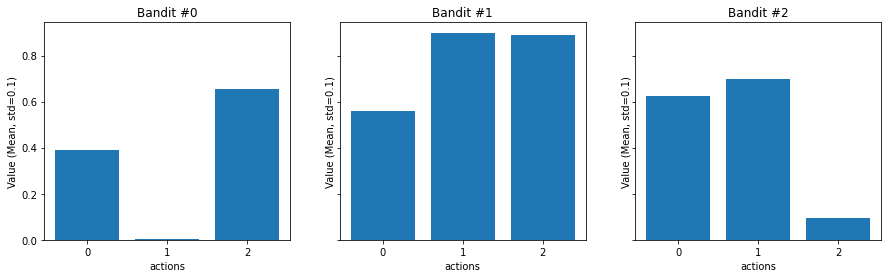

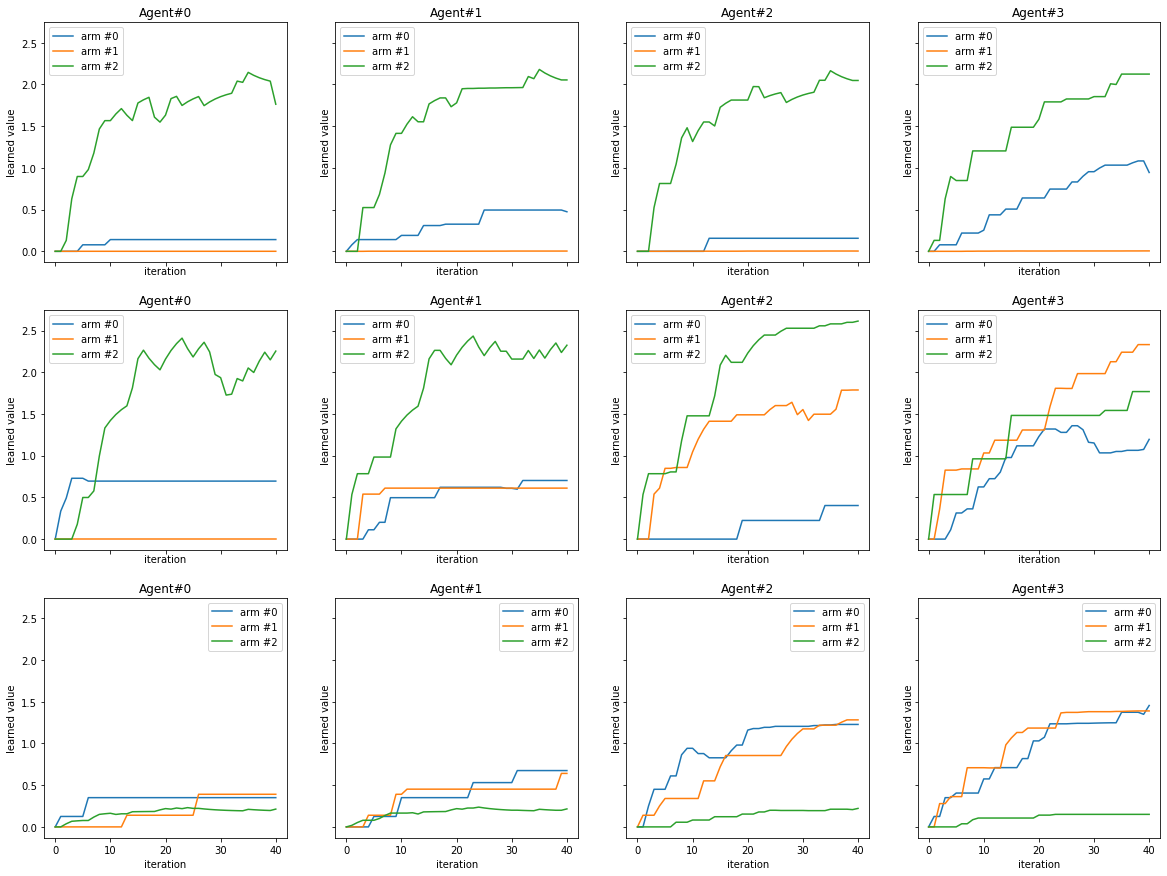

In [64]:
arm_values = n_k_armed_bandit(n_bandits, k)
rng = np.random.default_rng(seed=seed)
coop_multiplier = coop_bandit_multiplier(n_agents, strategy="linear")

values = np.zeros((iterations+1, n_agents, n_bandits, k))

for i in range(iterations):
    # Action selection
    actions = group_softmax_selection(values[i], beta, rng)
    
    # Execute action
    # rewards =  gauß_reward(arm_values, actions, n_agents, n_bandits, rng)
    rewards =  cooperative_reward(actions, arm_values, coop_multiplier, k)
    
    # Learning update
    values = group_rescola_wagner_update(values, i, rewards, actions, eta)


# Plots
plot_bandit_values(n_bandits, arm_values, k)
plot_agent_values_mb(n_agents, values, n_bandits)



# Social policy

In [35]:
# Social influence as inverse temperature for softmax -> high social influence leads to other exploiting your strategy
# Across action values?
values = np.ones(n_agents); social_influence = np.arange(n_agents)/n_agents
np.exp(values*social_influence) / np.sum(np.exp(values*social_influence))


array([0.16529618, 0.21224449, 0.27252732, 0.34993201])

In [36]:
# Chain of following? If you follow a follower, follow the leader

### Gamma Social Action values solving one bandit

In [37]:
# Social cooperation algorithm #1

# For every iteration i

# 1. Every agent chooses an action for every bandit (softmax)

# 2. The agents get the value of the other agents and choose with softmax which agent they want to follow. Social influence is the inverse temperature.

# 3. Parameter (gamma) if they execute social or individual action

# 4. Update Arm Values and Social Values (in case of imitation)


# TODO
# - Social influence parameter is missing


In [38]:
values = np.ones(n_agents); soc_influence = np.arange(n_agents)
np.exp(values*soc_influence) / np.sum(np.exp(values*soc_influence))


array([0.0320586 , 0.08714432, 0.23688282, 0.64391426])

In [51]:
def weighted_social_softmax_selection(values, n_agents, social_influence, rng):
    probs = np.exp(values*social_influence) / np.sum(np.exp(values*social_influence))
    return rng.choice(np.arange(len(probs)), size=n_agents, p=probs)

For agent **i**:

- Individual: Softmax over own values: $v_{ind, i} = sample(\frac{exp(v_i  \beta)}{\sum_j exp(v_{i,j}  \beta)}) $  

Social influence $\Theta$ is a n_agents x n_agents matrix.
- $\theta_i = \sum_j \Theta_{i,j}$

The sum of an agents influence on others $\theta_i$ is used to influence all agents (If an agents starts leading, others will follow more easily). 

$\theta_i$ is the inverse temperature of a softmax to scale agent i values. High $\theta$ &rarr; Exploit social connection.
- Social: Softmax over other agents chosen action values  $v_{soc, i} = sample(\frac{exp(v_{ind}  \theta)}{\sum_j exp(v_{ind, j}  \theta)})$


Chose to act social and imitate the sampled agents action with $P=\gamma$  
$\pi_i = \left\{
\begin{aligned}
v_{soc, i} \quad  \textit{U(0,1)} \leq \gamma \\
v_{ind, i} \quad  \textit{U(0,1)} \geq \gamma \\
\end{aligned}
\right.$

Social update:
- If an agent i imitates another agent j, the connection $\Theta_{i,j}$ is updated
- $\Theta_{i,j} = \Theta_{i,j} + TDE?$


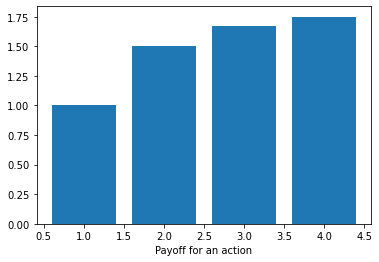

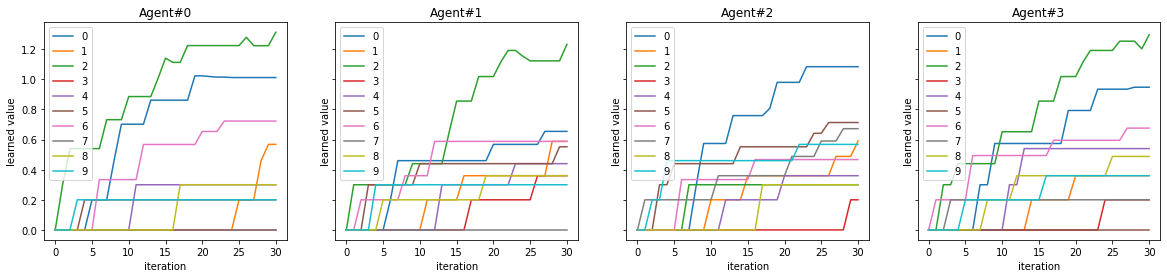

In [159]:
n_agents = 4
iterations = 30
k = 10
eta = 0.2
beta = 1.5
coop_strategy = "1/n" # "1/n" # "linear"
gamma = 0.2

seed = np.random.randint(100) # 0
rng = np.random.default_rng(seed=seed)

social_influence = np.ones((n_agents, n_agents))
# social_influence = np.ones(n_agents)


values = np.zeros((iterations+1, n_agents, k))

action_tracker = np.zeros((iterations, k))

for i in range(iterations):
    # Action selection
    actions = ma_softmax_selection(values[i], beta, rng)
    
    # Every agent evaluates the values of the actions other agents chose and chooses one(softmax)
    action_values = np.diag(values[i][:,actions.reshape(-1,1)].reshape(n_agents,n_agents))
    social_action_agent_index = weighted_social_softmax_selection(action_values, n_agents, social_influence.sum(axis=-1), rng)
    
    # With P=gamma they will actually imitate another agents action
    social_agents = rng.random(n_agents) <= gamma
    actions[social_agents] = actions[social_action_agent_index[social_agents]]
    
    # current_actions, counts = np.unique(actions, return_counts=True)
    # action_tracker[i][current_actions] = counts
    
    # Execute action
    rewards = coop_bandit(k, actions, strategy=coop_strategy)
    
    # Learning update
    values = ma_rescola_wagner_update(values, i, rewards, actions, eta)
    
    # Social influence update
    social_influence = social_influence.ravel()
    indexes = np.arange(n_agents)[social_agents] * n_agents + social_action_agent_index[social_agents]
    social_influence[indexes] += 0.5 # tbd (placeholder: Hardcoded Error)
    social_influence = social_influence.reshape(n_agents, n_agents)



# Plots
## Bandit value
x = np.arange(n_agents)
payoff= np.ones(n_agents)*n_agents
y = np.zeros(n_agents)

for po in x:
    payoff[po] = 0
    rewards = coop_bandit(k, payoff, coop_strategy)
    y[po] = rewards[0]
    
plt.bar(x=x+1, height=y)
plt.xlabel("Number of agents choosing the same action")
plt.xlabel("Payoff for an action")
plt.show()

## Agent value
plot_agent_values(n_agents, values, epsilon)
fig.savefig("Test.png")

In [161]:
social_influence

array([[2. , 1. , 1. , 1.5],
       [2. , 1.5, 1. , 1.5],
       [2.5, 1.5, 1. , 1. ],
       [3.5, 1.5, 1.5, 1.5]])

### Imitation based on social influence 

In [41]:
# Social cooperation algorithm #2

# For every iteration i

# 1. Every agent chooses an action for every bandit (softmax)

# 2. Agents choose another agents action based on social influence with P=gamma

# 3. If social influence is choosen, reinforce social influence (RW?)


# Idea: Start of with equally distributed social influence and adjust over time (limited ressource)
# Possibility to introduce biases (unequal distributions of social influence)


- Fully connected social influence matrix $\Omega$

For agent **i**:

- Individual: Softmax over own values: $v_{ind, i} = sample(\frac{exp(v_i  \beta)}{\sum_j exp(v_{i,j}  \beta)}) $  

Choose to act social and imitate the sampled agents action with $P=\gamma$  
- Social: Softmax over social_influence $\omega_i$:  $\pi_{soc, i} = sample(\frac{exp(\omega_i \beta)}{\sum_j exp(\omega_{i,j}  \beta)})$

Update social influence every iteration based on the imitated agents reward: 

- $\omega_{i,j} \leftarrow \omega_{i,j} + \alpha \cdot (\textit{reward}_{j} - \omega_{i,j})$


&rarr; Social influence represents performance


In [70]:
social_influence = np.zeros((n_agents,n_agents))
social_agents = rng.random(n_agents) <= 0.5

def social_influence_softmax(social_influences, beta, rng):
    probs = np.exp(social_influences * np.array(beta).reshape(-1,1))/ np.sum(np.exp(social_influences * np.array(beta).reshape(-1,1)), axis=-1).reshape(-1,1)
    return np.array([rng.choice(np.arange(n_agents), p=agent_probs) for agent_probs in probs])
    
social_influence_softmax(social_influence[social_agents], 1, rng)

array([2, 2])

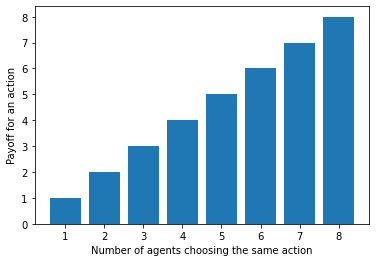

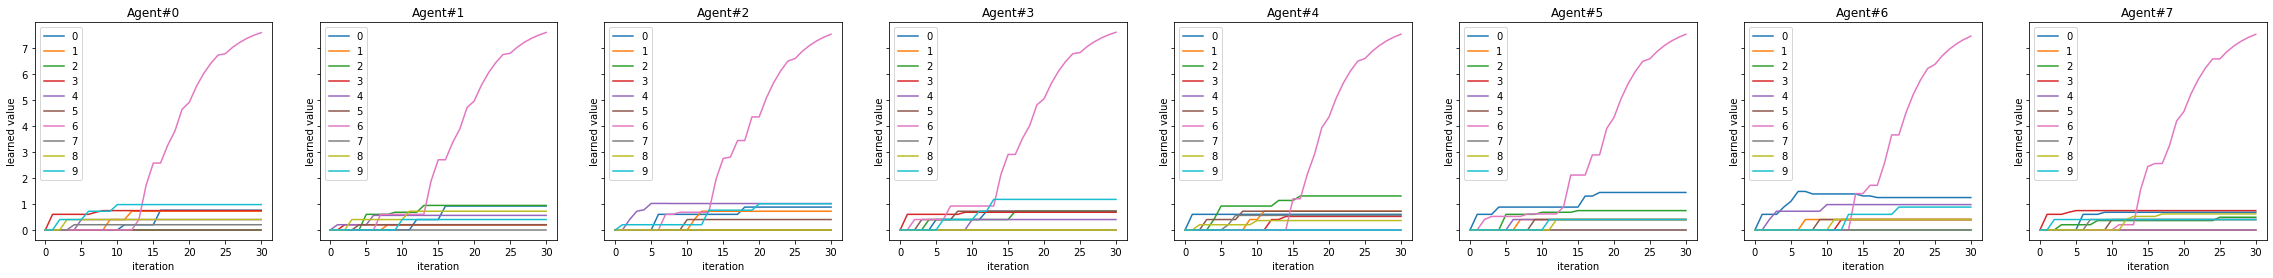

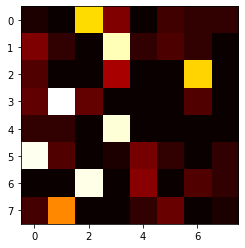

In [43]:
n_agents = 8
iterations = 30
k = 10
eta = 0.2
beta = np.ones(n_agents) * 1.5
coop_strategy = "linear" # "1/n" # "linear"

alpha = 0.2 # social learning rate

gamma = 0.5

seed = np.random.randint(100) # 0
rng = np.random.default_rng(seed=seed)

social_influence = np.zeros((n_agents, n_agents))


values = np.zeros((iterations+1, n_agents, k))
for i in range(iterations):
    # Action selection
    actions = ma_softmax_selection(values[i], beta, rng)
    
    # With gamma imiatet another based on social_influence
    social_agents = rng.random(n_agents) <= gamma
    if social_agents.sum() != 0:
        social_agents_influence = social_influence[social_agents]
        social_agents_imitated = social_influence_softmax(social_influence[social_agents], np.array(beta)[social_agents], rng)

        actions[social_agents] = actions[social_agents_imitated]

 
    # Execute action
    rewards = coop_bandit(k, actions, strategy=coop_strategy)
    
    
    # Learning update
    values = ma_rescola_wagner_update(values, i, rewards, actions, eta)
    
    # Adjust social_influence
    if social_agents.sum() != 0:
        current_social_influence = np.diag(social_influence[social_agents][:,np.array(social_agents_imitated)])
        social_influence_update = current_social_influence + alpha * (rewards[social_agents] - current_social_influence)
        social_agents_index = np.stack([np.where(social_agents == True)[0], social_agents_imitated], axis=-1)
        
        for i, index in enumerate(social_agents_index):
            social_influence[index[0], index[1]] = social_influence_update[i]
        

# Plots
## Bandit value
x = np.arange(n_agents)
payoff= np.ones(n_agents)*n_agents
y = np.zeros(n_agents)

for po in x:
    payoff[po] = 0
    rewards = coop_bandit(k, payoff, coop_strategy)
    y[po] = rewards[0]
    
plt.bar(x=x+1, height=y)
plt.xlabel("Number of agents choosing the same action")
plt.ylabel("Payoff for an action")
plt.show()

## Agent value
plot_agent_values(n_agents, values, epsilon)

## Social influence
# plt.bar(x=np.arange(n_agents), height = social_influence.mean(axis=-1))
# plt.xlabel("Agent"), plt.ylabel("Mean social influence")
plt.imshow(social_influence, cmap='hot', interpolation='nearest')

In [71]:
def bandit_social_imitation(n_agents, iterations, beta, coop_strategy, gamma, alpha, eta, k ,rng):
    social_influence = np.zeros((n_agents, n_agents))

    values = np.zeros((iterations+1, n_agents, k))
    for i in range(iterations):
        # Action selection
        actions = ma_softmax_selection(values[i], beta, rng)

        # With gamma imiatet another based on social_influence
        social_agents = rng.random(n_agents) <= gamma
        if social_agents.sum() != 0:
            social_agents_influence = social_influence[social_agents]
            social_agents_imitated = social_influence_softmax(social_influence[social_agents], np.ones(social_agents.sum()), rng)

            actions[social_agents] = actions[social_agents_imitated]


        # Execute action
        rewards = coop_bandit(k, actions, strategy=coop_strategy)


        # Learning update
        values = ma_rescola_wagner_update(values, i, rewards, actions, eta)

        # Adjust social_influence
        if social_agents.sum() != 0:
            current_social_influence = np.diag(social_influence[social_agents][:,np.array(social_agents_imitated)])
            social_influence_update = current_social_influence + alpha * (rewards[social_agents] - current_social_influence)
            social_agents_index = np.stack([np.where(social_agents == True)[0], social_agents_imitated], axis=-1)

            for i, index in enumerate(social_agents_index):
                social_influence[index[0], index[1]] = social_influence_update[i]
    
    return social_influence



Seed: 83 
Params: 3000 1/n 10


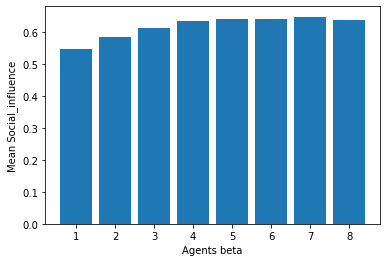

In [72]:
n_agents = 8
iterations = 40
k = 10
eta = 0.2
# beta = 1.5
beta = np.arange(1, n_agents+1)

coop_strategy = "1/n" # "1/n" # "linear"

alpha = 0.2 # social learning rate

gamma = 0.5

seed = np.random.randint(100) # 0
rng = np.random.default_rng(seed=seed)

n_simulations = 3000

print("Seed:", seed, "\nParams:", n_simulations, coop_strategy, k)

social_influence_mean=np.zeros((n_simulations, n_agents))

for _ in range(n_simulations):
    social_influence = bandit_social_imitation(n_agents, iterations, beta, coop_strategy, gamma, alpha, eta, k ,rng)
    social_influence_mean[_] = social_influence.mean(axis=0)

    
# Plots
plt.bar(x=np.arange(len(beta)), height=social_influence_mean.mean(axis=0))
plt.xticks(ticks= np.arange(len(beta)),labels=beta)
plt.xlabel("Agents beta")
plt.ylabel("Mean Social_influence")
plt.show()


### Policy function

- Agents have a policy function themselves, but they can get impacted by other agents one. So they can just copy an action, or actually incorporating it into their own function
- Maybe, if an agent assume another one is good enough (treshold) to trust, they actively give them influence, which enhances social scores for this agent
- 

#### Leader voting

In [46]:
# Social cooperation algorithm #3

# For every iteration i

# 1. Every agent chooses an action for every bandit (softmax)

# 2. Each agent determines one leader it may follow

# 3. If social influence is choosen, reinforce social connection


### Leadership Emergence attributes

- Leadership emerges to help **communication and cooperation**
- Diversity brings Information, which brings benefits (theoretically)
    - (Cognitive ressources) (value-in-diversity hypothesis) 
&rarr; More Information != Higher Leadership

- Mechanism defining who emerges as leadership:
    - Self efficacy/ communication/ Motivation-to-Lead
    - Established mechanics
    
- Distribution of information:
    - Heterogeneous or Homogeneous
    
&rarr; It is clear who is more likely to emerge


**BIAS** introduction
- A measurement or dynamic, which influences the Emergence (Granting) process
    - It will change team structure
- &rarr; Impacts information distribution

